# Lab exercise: Real NVP

In [ ]:
import numpy as np
import scipy.stats
import matplotlib.pyplot as plt
import itertools
import random
import math
import time

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.autograd as autograd

%matplotlib inline

In [ ]:
pltparams = {
    'legend.fontsize': 'x-large',
    'axes.labelsize': 'x-large',
    'axes.titlesize': 'x-large',
    'xtick.labelsize': 'x-large',
    'ytick.labelsize': 'x-large',
    'figure.titlesize': 'x-large',
    'savefig.dpi': 300,
}
plt.rcParams.update(pltparams)

# sns.set(font_scale = 1.2)

In [ ]:
# samples1-2 shape must be (n samples, 2)
def plot_samples(samples1, samples2=None):
    fig, ax = plt.subplots()

    ax.scatter(samples1[:,0], samples1[:,1], marker="x", color="blue")
    if samples2 is not None:
        ax.scatter(samples2[:,0], samples2[:,1], marker="x", color="red")

    return fig

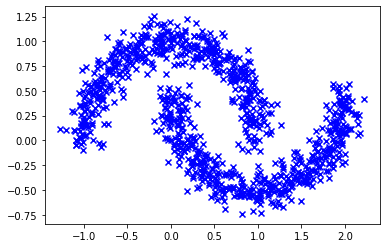

In [ ]:
import sklearn.datasets

target_samples, target_classes = sklearn.datasets.make_moons(1000, noise=0.1)
target_samples = torch.from_numpy(target_samples).float()

fig = plot_samples(target_samples)

Foward from z to x
\begin{align*}
g = z * exp(s(z * mask)) + t (z * mask)
\\
x = z * mask + g * (1 - mask)
\end{align*}

Inverse from x to z
\begin{align*}
g^{-1} = (x - t(x * mask)) * exp(-s(x * mask))
\\
z = x * mask + g^{-1} * (1 - mask)
\end{align*}

In [ ]:
class RealNVPLayer(nn.Module):
    def __init__(self, size, reverse=False):
        super().__init__()
        
        self.mask = torch.zeros(size, requires_grad=False)
        mid = int(size / 2)
        self.mid = mid
        if reverse:
            self.mask[mid:] = 1.
        else:
            self.mask[:mid] = 1.
        
        ## the two operations
        self.scale = nn.Sequential(
            nn.Linear(size, 10),
            nn.Tanh(),
            nn.Linear(10, size),
        )
        self.translate = nn.Sequential(
            nn.Linear(size, 10),
            nn.Tanh(),
            nn.Linear(10, size),
        )
        
    # project from the latent space to the observed space,
    # i.e. x = g(z)
    def forward(self, z):
        n_mask = 1. - self.mask
        z_masked = z * self.mask

        transform = z * torch.exp(self.scale(z_masked)) + self.translate(z_masked)
        x = z_masked + transform * n_mask

        return x
    
    # project from the observed space to the latent space,
    # this function also return the log det jacobian of this inv function
    def inv(self, x):
        n_mask = 1. - self.mask
        x_masked = x * self.mask
        
        scaled = self.scale(x_masked)
        reversetransform = (x - self.translate(x_masked)) * torch.exp(-scaled)
        z = x_masked + reversetransform * n_mask

        log_det_jacobian = torch.sum(-scaled * n_mask, dim=-1)

        return z, log_det_jacobian

In [ ]:
# Test!
layer = RealNVPLayer(2, reverse=False)

with torch.no_grad():
    x = torch.rand(1, 2)
    z, _ = layer.inv(x)
    xx = layer(z)

    print("In the 3 vectors below, the first element must be equal")
    print("This two vectors should be equal:")
    print(x)
    print(xx)
    print("This vector should be different to the two above")
    print(z)
print()

layer = RealNVPLayer(2, reverse=True)

with torch.no_grad():
    x = torch.rand(1, 2)
    z, _ = layer.inv(x)
    xx = layer(z)

    print("In the 3 vectors below, the second element must be equal")
    print("This two vectors should be equal:")
    print(x)
    print(xx)
    print("This vector should be different to the two above")
    print(z)

In the 3 vectors below, the first element must be equal
This two vectors should be equal:
tensor([[0.4336, 0.8737]])
tensor([[0.4336, 0.8737]])
This vector should be different to the two above
tensor([[0.4336, 0.9405]])

In the 3 vectors below, the second element must be equal
This two vectors should be equal:
tensor([[0.4532, 0.1506]])
tensor([[0.4532, 0.1506]])
This vector should be different to the two above
tensor([[0.5749, 0.1506]])


In [ ]:
class RealNVP(nn.Module):
    def __init__(self, size, n_layers):
        super().__init__()
        
        self.prior = torch.distributions.normal.Normal(torch.zeros(2), torch.ones(2))
        
        self.layers = nn.ModuleList(
                            RealNVPLayer(size, i % 2 == 0)
                            for i in range(n_layers)
        )
    
    def forward(self, z):
        x = z
        for i in range(len(self.layers)):
            x = self.layers[i](x)
        return x
    
    def inv(self, x):
        log_det_jacobian = 0.
        z = x
        for i in reversed(range(len(self.layers))):
            z, j = self.layers[i].inv(z)
            # remember here, we just have to sum all log det jacobians!
            log_det_jacobian = log_det_jacobian + j
        return z, log_det_jacobian

    
    def sample(self, n_samples):
        z = self.prior.sample((n_samples,))
        x = self(z)
        return x

    def log_prior(self, x):
        z, det = self.inv(x)
        ret = self.prior.log_prob(z).sum(1) + det
        
        return ret

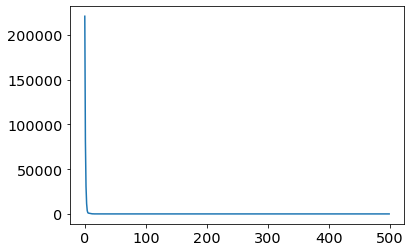

In [ ]:
trained_distrib = RealNVP(2, 50)
optimizer = torch.optim.Adam(trained_distrib.parameters(), lr=1e-3)

batch_size = 1000
losses = list()
for _ in range(500):
    for i in range(0, target_samples.shape[0], batch_size):
        batch = target_samples[i:i+batch_size]
        optimizer.zero_grad()

        loss = -trained_distrib.log_prior(batch).mean()
        losses.append(loss.item())

        loss.backward()
        torch.nn.utils.clip_grad_norm_(trained_distrib.parameters(), 5)
        optimizer.step()
    
plt.plot(np.arange(len(losses)), losses)

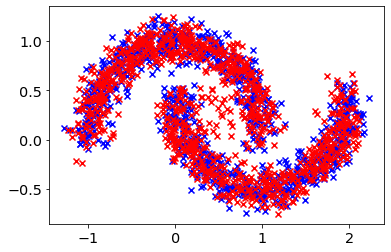

In [ ]:
# sample from the model
with torch.no_grad():
    samples = trained_distrib.sample(1000)
    fig = plot_samples(target_samples, samples)

fig.savefig("sample.pdf")

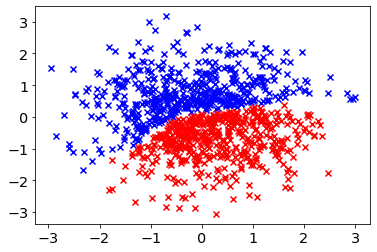

In [ ]:
# print the latent space corresponding to each half moon in a different color
with torch.no_grad():
    source_sample1, _ = trained_distrib.inv(target_samples[target_classes == 0])
    source_sample2, _ = trained_distrib.inv(target_samples[target_classes == 1])
    fig = plot_samples(source_sample1, source_sample2)

fig.savefig("latent.pdf")